In [ ]:
!pip install -q torch torchvision scikit-learn opencv-python matplotlib pillow tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!mkdir -p "/content/drive/MyDrive/casia_data"
print("Drive folder ready: /content/drive/MyDrive/casia_data")


Drive folder ready: /content/drive/MyDrive/casia_data


In [1]:
from google.colab import files
print("upload kaggle.json.")
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle


upload kaggle.json.


Saving kaggle.json to kaggle.json
total 4
-rw------- 1 root root 67 Nov 22 13:06 kaggle.json


In [ ]:
!kaggle datasets download -d sophatvathana/casia-dataset -p /content --force


Dataset URL: https://www.kaggle.com/datasets/sophatvathana/casia-dataset
License(s): unknown
 99% 5.17G/5.22G [01:50<00:00, 183MB/s]
100% 5.22G/5.22G [01:50<00:00, 50.6MB/s]


In [ ]:
!unzip -q -o /content/casia-dataset.zip -d "/content/drive/MyDrive/casia_data"
print("Unzip to Drive finished.")
!du -sh "/content/drive/MyDrive/casia_data" || true


Unzip to Drive finished.
6.7G	/content/drive/MyDrive/casia_data


In [ ]:
!rm -rf /content/casia
!cp -r "/content/drive/MyDrive/casia_data" "/content/casia"
!ls -la /content/casia


total 20
drwx------ 5 root root 4096 Nov 19 14:47 .
drwxr-xr-x 1 root root 4096 Nov 19 14:43 ..
drwx------ 4 root root 4096 Nov 19 14:47 casia
drwx------ 4 root root 4096 Nov 19 14:44 CASIA1
drwx------ 4 root root 4096 Nov 19 14:45 CASIA2


In [ ]:
!find /content/casia -maxdepth 3 -type d | sed -n '1,200p'
print("---- sample files (CASIA2/Tp) ----")
!ls -la /content/casia/CASIA2/Tp | head -n 20


/content/casia
/content/casia/casia
/content/casia/casia/CASIA2
/content/casia/casia/CASIA2/Tp
/content/casia/casia/CASIA2/Au
/content/casia/casia/CASIA1
/content/casia/casia/CASIA1/Sp
/content/casia/casia/CASIA1/Au
/content/casia/CASIA2
/content/casia/CASIA2/Tp
/content/casia/CASIA2/Au
/content/casia/CASIA1
/content/casia/CASIA1/Sp
/content/casia/CASIA1/Au
---- sample files (CASIA2/Tp) ----
total 3086120
drwx------ 2 root root  364544 Nov 19 14:47 .
drwx------ 4 root root    4096 Nov 19 14:45 ..
-rw------- 1 root root   32768 Nov 19 14:45 Thumbs.db
-rw------- 1 root root  854772 Nov 19 14:45 Tp_D_CND_M_N_ani00018_sec00096_00138.tif
-rw------- 1 root root  308640 Nov 19 14:45 Tp_D_CND_M_N_art00076_art00077_10289.tif
-rw------- 1 root root  664768 Nov 19 14:45 Tp_D_CND_M_N_art00077_art00076_10290.tif
-rw------- 1 root root  659892 Nov 19 14:45 Tp_D_CND_S_N_ani00073_ani00068_00193.tif
-rw------- 1 root root  626436 Nov 19 14:45 Tp_D_CND_S_N_ind00078_ind00077_00476.tif
-rw------- 1 root r

In [ ]:
import os

ROOT = "/content/casia/CASIA2"
AU_PATH = os.path.join(ROOT, "Au")
TP_PATH = os.path.join(ROOT, "Tp")

valid_ext = {".jpg",".jpeg",".png",".tif",".tiff",".bmp"}

def clean_folder(path):
    removed = 0
    for fname in os.listdir(path):
        full = os.path.join(path, fname)
        if os.path.isdir(full):
            continue
        ext = os.path.splitext(fname)[1].lower()
        if ext not in valid_ext:
            print("Removing non-image:", full)
            try:
                os.remove(full)
                removed += 1
            except Exception as e:
                print("Failed remove:", full, e)
    print(f"Cleaned {path} - removed {removed} files")

clean_folder(AU_PATH)
clean_folder(TP_PATH)
print("Cleaning done.")


Removing non-image: /content/casia/CASIA2/Au/Thumbs.db
Cleaned /content/casia/CASIA2/Au - removed 1 files
Removing non-image: /content/casia/CASIA2/Tp/Thumbs.db
Cleaned /content/casia/CASIA2/Tp - removed 1 files
Cleaning done.


In [ ]:
import os
au_files = [os.path.join(AU_PATH,f) for f in os.listdir(AU_PATH) if os.path.splitext(f)[1].lower() in valid_ext]
tp_files = [os.path.join(TP_PATH,f) for f in os.listdir(TP_PATH) if os.path.splitext(f)[1].lower() in valid_ext]

print("Authentic (Au):", len(au_files))
print("Tampered (Tp):", len(tp_files))
print("Total:", len(au_files)+len(tp_files))

print("Example Au:", au_files[:3])
print("Example Tp:", tp_files[:3])


Authentic (Au): 7491
Tampered (Tp): 5123
Total: 12614
Example Au: ['/content/casia/CASIA2/Au/Au_arc_00041.jpg', '/content/casia/CASIA2/Au/Au_cha_30229.jpg', '/content/casia/CASIA2/Au/Au_ind_30054.jpg']
Example Tp: ['/content/casia/CASIA2/Tp/Tp_D_NRD_L_B_arc20049_arc20049_02480.tif', '/content/casia/CASIA2/Tp/Tp_S_NRN_S_N_ani20054_ani20054_02097.tif', '/content/casia/CASIA2/Tp/Tp_S_NNN_S_N_cha00008_cha00008_11157.jpg']


In [ ]:

from sklearn.model_selection import train_test_split
image_paths = au_files + tp_files
labels = [0]*len(au_files) + [1]*len(tp_files)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print("Train:", len(train_paths), "Test:", len(test_paths))


Train: 10091 Test: 2523


In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CasiaDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            return self.__getitem__((idx+1) % len(self.paths))
        if self.transform:
            img = self.transform(img)
        return img, label


In [ ]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = CasiaDataset(train_paths, train_labels, transform=train_transform)
test_ds  = CasiaDataset(test_paths,  test_labels,  transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=0)

print("Dataloaders ready. Train batches:", len(train_loader), "Test batches:", len(test_loader))


Dataloaders ready. Train batches: 631 Test batches: 158


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


In [ ]:
from tqdm import tqdm
best_val_acc = 0.0
EPOCHS = 8

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for imgs, labs in pbar:
        imgs = imgs.to(device); labs = labs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss/((pbar.n+1)))

    model.eval()
    preds=[]; trues=[]
    with torch.no_grad():
        for imgs, labs in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, p = torch.max(outputs,1)
            preds.extend(p.cpu().numpy())
            trues.extend(labs.numpy())
    from sklearn.metrics import accuracy_score
    val_acc = accuracy_score(trues, preds)
    print(f"Epoch {epoch+1} finished. Val Acc: {val_acc:.4f}, Loss: {running_loss/len(train_loader):.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/forgery_resnet50_best.pth")
        print("Saved best model with val_acc:", best_val_acc)


Epoch 1/8: 100%|██████████| 631/631 [03:11<00:00,  3.30it/s, loss=0.486]


Epoch 1 finished. Val Acc: 0.8086, Loss: 0.4864
Saved best model with val_acc: 0.8085612366230678


Epoch 2/8: 100%|██████████| 631/631 [02:56<00:00,  3.57it/s, loss=0.373]


Epoch 2 finished. Val Acc: 0.8351, Loss: 0.3728
Saved best model with val_acc: 0.8351169242964724


Epoch 3/8: 100%|██████████| 631/631 [02:43<00:00,  3.85it/s, loss=0.336]


Epoch 3 finished. Val Acc: 0.8490, Loss: 0.3357
Saved best model with val_acc: 0.8489892984542212


Epoch 4/8: 100%|██████████| 631/631 [02:43<00:00,  3.85it/s, loss=0.301]


Epoch 4 finished. Val Acc: 0.8434, Loss: 0.3009


Epoch 5/8: 100%|██████████| 631/631 [02:43<00:00,  3.85it/s, loss=0.276]


Epoch 5 finished. Val Acc: 0.8565, Loss: 0.2757
Saved best model with val_acc: 0.856520015854142


Epoch 6/8: 100%|██████████| 631/631 [02:44<00:00,  3.84it/s, loss=0.253]


Epoch 6 finished. Val Acc: 0.8423, Loss: 0.2529


Epoch 7/8: 100%|██████████| 631/631 [02:44<00:00,  3.83it/s, loss=0.234]


Epoch 7 finished. Val Acc: 0.8545, Loss: 0.2336


Epoch 8/8: 100%|██████████| 631/631 [02:46<00:00,  3.80it/s, loss=0.224]


Epoch 8 finished. Val Acc: 0.8331, Loss: 0.2240


In [ ]:

model.load_state_dict(torch.load("/content/drive/MyDrive/forgery_resnet50_best.pth"))
model.eval()

preds=[]; trues=[]
with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, p = torch.max(outputs,1)
        preds.extend(p.cpu().numpy())
        trues.extend(labs.numpy())

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(trues,preds))
print(classification_report(trues,preds, target_names=["Authentic","Tampered"]))
cm = confusion_matrix(trues,preds)
print("Confusion matrix:\n", cm)


Accuracy: 0.856520015854142
              precision    recall  f1-score   support

   Authentic       0.93      0.82      0.87      1498
    Tampered       0.78      0.91      0.84      1025

    accuracy                           0.86      2523
   macro avg       0.85      0.86      0.85      2523
weighted avg       0.87      0.86      0.86      2523

Confusion matrix:
 [[1229  269]
 [  93  932]]


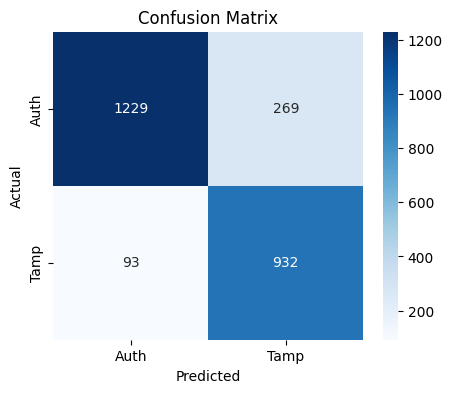

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Auth","Tamp"], yticklabels=["Auth","Tamp"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


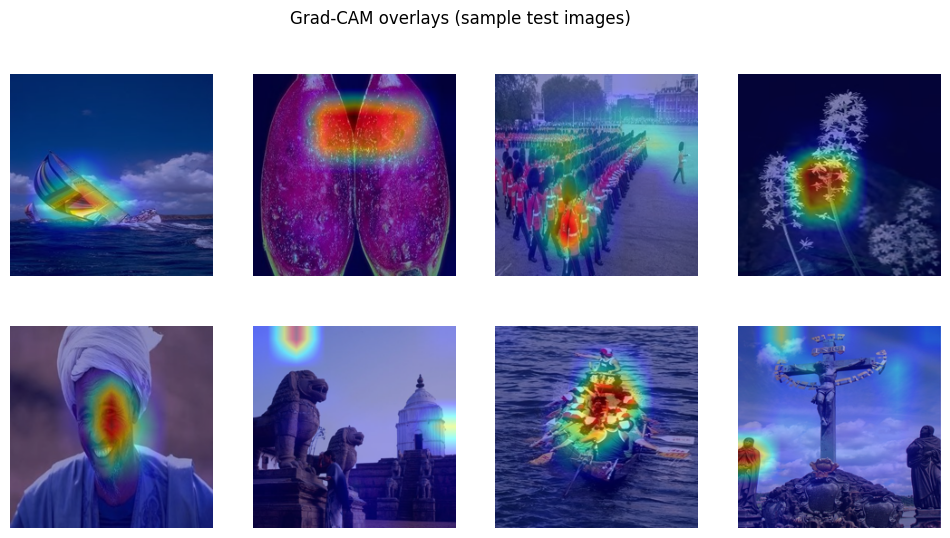

In [ ]:

import torch.nn.functional as F
def grad_cam(model, img_tensor, target_class=None, layer_name="layer4"):
    model.eval()
    img_tensor = img_tensor.unsqueeze(0).to(device)

    conv_output = None
    grads = None
    def forward_hook(module, inp, out):
        nonlocal conv_output
        conv_output = out.detach()
    def backward_hook(module, grad_in, grad_out):
        nonlocal grads
        grads = grad_out[0].detach()

    for name, module in model.named_modules():
        if name==layer_name:
            h1 = module.register_forward_hook(forward_hook)
            h2 = module.register_backward_hook(backward_hook)
            break

    outputs = model(img_tensor)
    if target_class is None:
        target_class = outputs.argmax(dim=1).item()
    score = outputs[0, target_class]
    model.zero_grad()
    score.backward(retain_graph=True)

    weights = torch.mean(grads, dim=(2,3), keepdim=True)  # GAP on grads
    cam = torch.sum(weights * conv_output, dim=1).squeeze(0)
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    cam = cam.cpu().numpy()

    h1.remove(); h2.remove()
    return cam


import numpy as np
import cv2
model.eval()
fig=plt.figure(figsize=(12,6))
count=0
for i in range(0, min(8,len(test_paths)), 1):
    path = test_paths[i]
    img = Image.open(path).convert("RGB")
    img_tensor = test_transform(img)
    cam = grad_cam(model, img_tensor, layer_name="layer4")
    heatmap = cv2.resize(cam, (224,224))
    heatmap = (heatmap * 255).astype("uint8")
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_np = np.array(img.resize((224,224)))[:,:,::-1]  # RGB->BGR for cv2
    overlay = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

    ax = fig.add_subplot(2,4,count+1)
    ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    count += 1
plt.suptitle("Grad-CAM overlays (sample test images)")
plt.show()


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/forgery_resnet50_final.pth")
print("Saved final model to Drive.")


Saved final model to Drive.


In [ ]:
import os

bad_files = ["Thumbs.db", "desktop.ini"]

for root, dirs, files in os.walk("/content/casia"):
    for f in files:
        if f in bad_files:
            try:
                os.remove(os.path.join(root, f))
                print("Removed:", f)
            except:
                pass

print("Cleaning complete.")


Cleaning complete.


In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
class CasiaDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!rm -rf /content/casia
!cp -r "/content/drive/MyDrive/casia_data/CASIA2" "/content/casia"


In [ ]:
authentic_dir = "/content/casia/Au"
tampered_dir  = "/content/casia/Tp"

authentic_files = [os.path.join(authentic_dir, f) for f in os.listdir(authentic_dir)]
tampered_files  = [os.path.join(tampered_dir, f) for f in os.listdir(tampered_dir)]

all_files = authentic_files + tampered_files
labels = [0]*len(authentic_files) + [1]*len(tampered_files)


In [ ]:
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42
)


In [ ]:
train_dataset = CasiaDataset(train_files, train_labels, transform)
val_dataset   = CasiaDataset(val_files, val_labels, transform)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

EPOCHS = 10

train_losses = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Training Loss
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            vloss = criterion(output, labels)
            val_loss += vloss.item()

            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


 57%|█████▋    | 180/316 [00:59<00:44,  3.03it/s]


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipython-input-963627666.py", line 14, in __getitem__
    img = Image.open(img_path).convert("RGB")
          ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/PIL/Image.py", line 3580, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file '/content/casia/Tp/Thumbs.db'


In [ ]:
import os
from PIL import Image

root_dir = "/content/casia"
valid_exts = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]

removed = 0

for root, dirs, files in os.walk(root_dir):
    for f in files:
        full_path = os.path.join(root, f)
        ext = os.path.splitext(f)[1].lower()

        # Remove non-image files
        if ext not in valid_exts:
            try:
                os.remove(full_path)
                removed += 1
                print("Removed:", full_path)
            except:
                pass

print("Cleaning complete. Total removed:", removed)


Removed: /content/casia/Tp/Thumbs.db
Removed: /content/casia/Au/Thumbs.db
Cleaning complete. Total removed: 2


In [ ]:
import os
from PIL import Image

authentic_dir = "/content/casia/Au"
tampered_dir  = "/content/casia/Tp"

valid_authentic = []
valid_tampered = []

def verify_and_collect(folder, target_list):
    for f in os.listdir(folder):
        path = os.path.join(folder, f)
        try:
            Image.open(path).verify()   # check image integrity
            target_list.append(path)
        except:
            print("Corrupted/Unreadable Removed:", path)
            try:
                os.remove(path)
            except:
                pass

verify_and_collect(authentic_dir, valid_authentic)
verify_and_collect(tampered_dir, valid_tampered)

print("Authentic:", len(valid_authentic))
print("Tampered:", len(valid_tampered))


Authentic: 7491
Tampered: 5123


In [ ]:
from sklearn.model_selection import train_test_split

all_files = valid_authentic + valid_tampered
labels = [0]*len(valid_authentic) + [1]*len(valid_tampered)

train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42
)

len(train_files), len(val_files)


(10091, 2523)

In [ ]:
from torchvision import transforms
import torch
from torch.utils.data import Dataset
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

class CasiaDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
from torch.utils.data import DataLoader

train_dataset = CasiaDataset(train_files, train_labels, transform)
val_dataset   = CasiaDataset(val_files,   val_labels,   transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)


In [ ]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
from tqdm import tqdm

EPOCHS = 10

train_losses = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)


    model.eval()
    correct = 0
    total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            vloss = criterion(outputs, labels)
            val_running_loss += vloss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_acc = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


100%|██████████| 316/316 [01:42<00:00,  3.10it/s]


Epoch [1/10] | Train Loss: 0.5170 | Val Loss: 0.5076 | Val Acc: 0.7630


100%|██████████| 316/316 [01:40<00:00,  3.14it/s]


Epoch [2/10] | Train Loss: 0.4103 | Val Loss: 0.4895 | Val Acc: 0.7765


100%|██████████| 316/316 [01:40<00:00,  3.15it/s]


Epoch [3/10] | Train Loss: 0.3662 | Val Loss: 0.4802 | Val Acc: 0.7749


100%|██████████| 316/316 [01:40<00:00,  3.16it/s]


Epoch [4/10] | Train Loss: 0.3400 | Val Loss: 0.5149 | Val Acc: 0.7562


100%|██████████| 316/316 [01:40<00:00,  3.14it/s]


Epoch [5/10] | Train Loss: 0.3182 | Val Loss: 0.4443 | Val Acc: 0.7780


100%|██████████| 316/316 [01:40<00:00,  3.15it/s]


Epoch [6/10] | Train Loss: 0.2982 | Val Loss: 0.5495 | Val Acc: 0.7368


100%|██████████| 316/316 [01:40<00:00,  3.16it/s]


Epoch [7/10] | Train Loss: 0.2838 | Val Loss: 0.5441 | Val Acc: 0.7558


100%|██████████| 316/316 [01:40<00:00,  3.15it/s]


Epoch [8/10] | Train Loss: 0.2764 | Val Loss: 0.5506 | Val Acc: 0.7519


100%|██████████| 316/316 [01:40<00:00,  3.16it/s]


Epoch [9/10] | Train Loss: 0.2611 | Val Loss: 0.6636 | Val Acc: 0.7610


100%|██████████| 316/316 [01:40<00:00,  3.16it/s]


Epoch [10/10] | Train Loss: 0.2530 | Val Loss: 0.5921 | Val Acc: 0.7554


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["Authentic", "Tampered"]))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:

              precision    recall  f1-score   support

   Authentic       0.83      0.75      0.79      1529
    Tampered       0.67      0.76      0.71       994

    accuracy                           0.76      2523
   macro avg       0.75      0.76      0.75      2523
weighted avg       0.77      0.76      0.76      2523


Confusion Matrix:
[[1147  382]
 [ 235  759]]


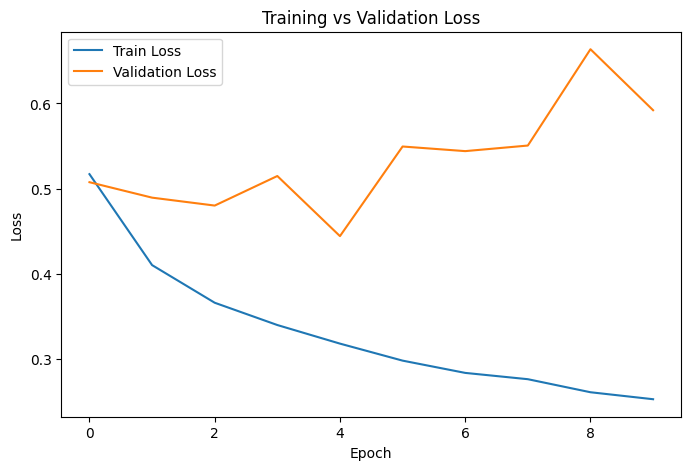

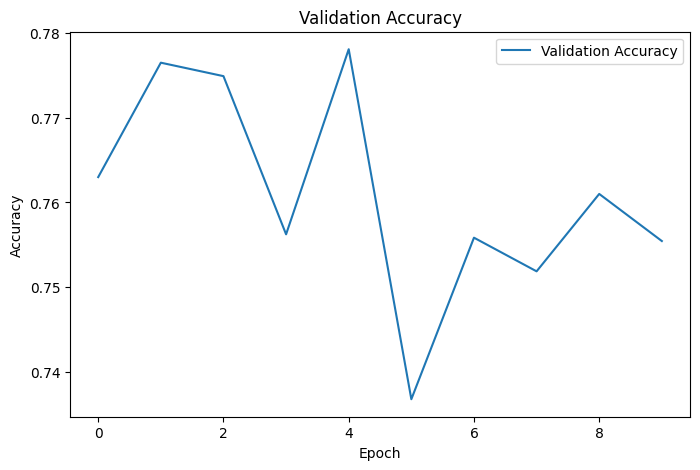

In [ ]:
import matplotlib.pyplot as plt

# Loss curve
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(8,5))
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
save_path = "/content/drive/MyDrive/forgery_resnet50_final.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/forgery_resnet50_final.pth


In [ ]:
history = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accs": val_accs
}

import pickle
with open("/content/drive/MyDrive/history_resnet50.pkl", "wb") as f:
    pickle.dump(history, f)

print("History saved.")


History saved.
